# Modeling

In [1]:
import pandas as pd
from datetime import timedelta

#### Import data

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

In [4]:
toy_products_df.shape

(3125, 6)

In [5]:
toy_dataset_df.shape

(32151, 23)

#### Clean data

In [6]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

In [54]:
toy_dataset_df = toy_dataset_df[toy_dataset_df['point_of_sales']=='Online Store']

In [55]:
toy_dataset_df.shape

(29338, 25)

#### Create train, test data sets based on date split

In [56]:
split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [57]:
test_dates = test['timestamp'].dt.date.unique().tolist()
len(test_dates)

230

In [106]:
train_dates = train['timestamp'].dt.date.unique().tolist()
len(train_dates)

894

In [58]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

81.98

In [59]:
print(train.shape)
print(test.shape)

(24050, 25)
(5288, 25)


### Baseline Model - top 10 titles over previous week

In [60]:
def get_top10_title_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'title_rank']
    return top10_last_wk_df

In [61]:
get_top10_title_preds(as_of_dt='2021-08-13')

,title_pred,prev_wk_cnt,transaction_date,title_rank
4,Olympic Running,64,2021-08-13,1.0
2,Iron Running,31,2021-08-13,2.0
8,Vanguard Sandal,12,2021-08-13,3.0
0,Classic Sneaker,9,2021-08-13,4.0
1,Hustler Boot,9,2021-08-13,5.0
3,League Running,8,2021-08-13,6.0
5,Rogue Sneaker,8,2021-08-13,7.0
6,Scalar Sandal,4,2021-08-13,8.0
7,Stacked Hiking Boot,2,2021-08-13,9.0


In [62]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','title_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [63]:
assert full_eval_df.shape[0] == test.shape[0]

In [64]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,product_title_gender,rating,title_pred,title_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,30908.0,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running-Kids,1,Olympic Running,1.0
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,75068.0,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running-Men,1,Olympic Running,1.0
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Men,1,Iron Running,3.0
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Women,1,Iron Running,3.0
4,10892,2022-05-22 06:00:00,13099258178146683672,5081644438403400480,266.0,Iron Running,Dartmouth Green,Men,Running,11.0,...,42759.0,6585.0,72274.0,88910.0,66.4,6.9,Iron Running-Men,1,Iron Running,3.0


In [65]:
# Percent of test purchases that were in top 10
full_eval_df['title_rank'].count() / full_eval_df.shape[0]

0.9517776096822995

In [66]:
# average rec rank of purchases that fell in top 10
full_eval_df['title_rank'].mean()

3.7264057222332605

<AxesSubplot:>

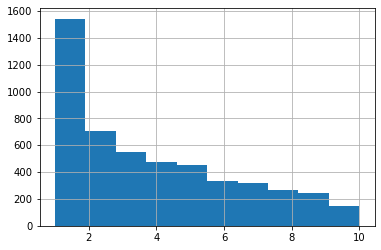

In [67]:
full_eval_df['title_rank'].hist()

### Baseline model - top 10 title-gender products over previous week

In [68]:
def get_top10_title_gender_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular title-gender products sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & 
                                  (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby(['product_title', 'product_gender']).size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'gender_pred', 'prev_wk_cnt', 'pred_rank']
    top10_last_wk_df['transaction_date'] = as_of_dt
    return top10_last_wk_df

In [69]:
get_top10_title_gender_preds(as_of_dt = '2022-08-13', prev_days=7, top_n=10)

,title_pred,gender_pred,prev_wk_cnt,pred_rank,transaction_date
13,Olympic Running,Women,26,1.0,2022-08-13
8,League Running,Women,16,2.0,2022-08-13
0,Bejeweled Boot,Unisex,15,3.0,2022-08-13
6,Iron Running,Women,15,4.0,2022-08-13
4,Hustler Boot,Women,12,5.0,2022-08-13
14,Olympic Running,Youth,8,6.0,2022-08-13
10,Marathon Running,Women,8,7.0,2022-08-13
21,Stacked Hiking Boot,Women,7,8.0,2022-08-13
17,Rogue Sneaker,Women,7,9.0,2022-08-13
5,Iron Running,Men,7,10.0,2022-08-13


In [70]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [71]:
assert full_eval_df.shape[0] == test.shape[0]

In [72]:
# Percent of test purchases that were in top 10
full_eval_df['pred_rank'].count() / full_eval_df.shape[0]

0.6348335854765507

In [73]:
# average rec rank of purchases that fell in top 10
full_eval_df['pred_rank'].mean()

4.207625856419422

<AxesSubplot:>

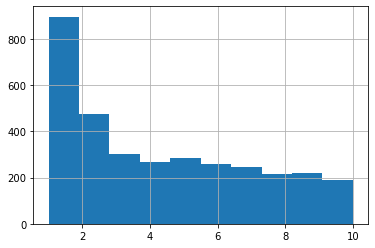

In [74]:
full_eval_df['pred_rank'].hist()

In [75]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,product_title_gender,rating,title_pred,gender_pred,pred_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running-Kids,1,NaN,NaN,NaN
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running-Men,1,NaN,NaN,NaN
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Men,1,NaN,NaN,NaN
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,33057.0,85768.0,111260.0,66.1,4.1,Iron Running-Women,1,Iron Running,Women,3.0
4,10892,2022-05-22 06:00:00,13099258178146683672,5081644438403400480,266.0,Iron Running,Dartmouth Green,Men,Running,11.0,...,6585.0,72274.0,88910.0,66.4,6.9,Iron Running-Men,1,NaN,NaN,NaN


In [78]:
# create title-gender field
toy_dataset_df.loc[:,'product_title_gender'] = toy_dataset_df['product_title'] + '-' + toy_dataset_df['product_gender']

### Collaborative Filtering

In [31]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split

In [82]:
# Add a binary rating column
toy_dataset_df.loc[:,"rating"] = 1

In [83]:
# Define the Reader object
reader = Reader(rating_scale=(0, 1))

In [84]:
# Load the data into the Surprise dataset format
data = Dataset.load_from_df(toy_dataset_df[["hash_customer", "product_title_gender", "rating"]], reader)

In [85]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [86]:
# Define the algorithm
sim_options = {"name": "cosine", "user_based": False}
algo = KNNBasic(sim_options=sim_options)

In [87]:
# Train the model on the training set
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [88]:
# Test the model on the test set
predictions = algo.test(testset)

In [89]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [90]:
top_n

{8275062546790707801: ['Olympic Running-Women'],
 7453143749300234379: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Classic Sneaker-Women',
  'Olympic Running-Women',
  'Rogue Sneaker-Women',
  'Classic Sneaker-Women',
  'Scalar Sandal-Women',
  'Olympic Running-Women'],
 6280921628500077617: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 934772523603658765: ['Hustler Boot-Men',
  'Corner Sandal-Unisex',
  'Vanguard Sandal-Men',
  'Corner Sandal-Unisex',
  'Marathon Running-Men',
  'Corner Sandal-Unisex',
  'Training Sneaker-Men',
  'Iron Running-Men',
  'Olympic Running-Women',
  'Marathon Running-Men'],
 14711778386631295359: ['League Running-Men'],
 3088306778024088919: ['Olympic Running-Women',
  'Olympic Running-Kids',
  'Olympic Running-Youth',
  'League Running-Women'],
 1311068505070111502: ['Rogue Sneaker-Men'],
 168847860845

In [93]:
from surprise import SVD

In [94]:
# Define the algorithm
algo = SVD(verbose=True, n_epochs=10)

# Train the model on the training set
algo.fit(trainset)

# Test the model on the test set
predictions = algo.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [100]:
from surprise.model_selection import cross_validate

In [101]:
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [102]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [103]:
top_n

{8275062546790707801: ['Olympic Running-Women'],
 7453143749300234379: ['Classic Sneaker-Women',
  'Rogue Sneaker-Women',
  'Classic Sneaker-Women',
  'Classic Sneaker-Women',
  'Classic Sneaker-Women',
  'Rogue Sneaker-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 6280921628500077617: ['Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women',
  'Olympic Running-Women'],
 934772523603658765: ['Corner Sandal-Unisex',
  'Corner Sandal-Unisex',
  'Marathon Running-Men',
  'Corner Sandal-Unisex',
  'Iron Running-Men',
  'Marathon Running-Men',
  'Marathon Running-Men',
  'Hustler Boot-Women',
  'Olympic Running-Women',
  'Hustler Boot-Men'],
 14711778386631295359: ['League Running-Men'],
 3088306778024088919: ['Olympic Running-Kids',
  'Olympic Running-Youth',
  'League Running-Women',
  'Olympic Running-Women'],
 1311068505070111502: ['Rogue Sneaker-Men'],
 1688478608458

## Binary classifier

In [105]:
import random

In [111]:
train.columns

Index(['Unnamed: 0', 'timestamp', 'transaction_id', 'hash_customer',
       'sale_amount', 'product_title', 'product_color', 'product_gender',
       'product_category', 'product_size', 'referrer_source', 'point_of_sales',
       'zip_tot_hh', 'zip_avg_hh_size', 'zip_avg_fam_size', 'zip_med_age',
       'zip_male_female_ratio', 'zip_tot_pop', 'zip_tot_white_nh',
       'zip_med_hh_income', 'zip_mean_hh_income', 'zip_pct_emp_lf',
       'zip_unemp_rate', 'product_title_gender', 'rating'],
      dtype='object')

In [112]:
positive_samples = train[['timestamp', 'transaction_id', 'hash_customer', 
                          'sale_amount', 'product_title', 'product_color', 'product_gender',
                          'product_category', 'referrer_source']]

In [114]:
positive_samples.loc[:,'purchase'] = 1

In [123]:
positive_samples.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1
2,2019-10-18 06:00:00,5418521222138237582,15372924648196696535,141.0,Rogue Sneaker,Electric Purple,Women,Sneaker,Direct,1
3,2021-10-03 19:00:00,13807911046559617059,15372924648196696535,147.0,Classic Sneaker,Electric Purple,Women,Sneaker,Direct,1
4,2019-10-18 09:00:00,17285359619674932653,10040016928726048703,194.0,Olympic Running,Stormcloud,Women,Running,Search,1


In [125]:
positive_samples[positive_samples['hash_customer']==118171218419602151]

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,1


In [124]:
for idx, dt, in enumerate(positive_samples['timestamp'].dt.date.unique()[0:20]):
    print(idx, end=',')
    print(dt)
    
    purchasers = positive_samples[positive_samples['timestamp'].dt.date == dt]['hash_customer'].unique()
    for purchaser in purchasers:
        print(purchasers)
        
        negative_samples = positive_samples[(positive_samples['timestamp'].dt.date == dt) & (positive_samples['hash_customer']==purchaser)]
    

0,2019-10-17
[118171218419602151]
1,2022-03-26
[  118171218419602151  8473937388788316230 15891019939387205085
 16644566156899952523 15218724473166180516  5493640445945313851
 13723558451201059581  1893038609291547674 10947789410499868749
  3714764013779167386  7079956470180363456  1254093789900453774
 11640820295223231033 10235253253554693809 14624120655785680998
 15457216657249668300]
2,2019-10-18
[15372924648196696535 10040016928726048703  1043293858936909271
 15662680612455577070]
3,2021-10-03
[15372924648196696535 16146811005805960040  2312068498068328940
 15241960575116212090 14350517519610395729   823529713573908561
 12154327814660840481 14933406596462594681 14482116821894508742
  4501594940841342175 12090072858737866907  9228724623018846820
  3144315755923230086  6687779432499401901 12652813572306749430
 15135722890801285862  7037142999552225962 13003737835182720351
 15142316626863755675  7497112675522655719  2891001318810175521
 10816304920142374220]
4,2021-06-23
[100400169287

[ 9901926241040755351 16884786084583649830  8727750091080194726
 11994816079165017553 15403965232328953554  1728388905758467156
  7344596462970732019 13913515157751387772  3482337665673897708
 14555937084503475826 12843747351575404677]
18,2021-11-27
[ 9901926241040755351  1909922509383162445  5153851872049777936
 11496697443650097406  9772246498608403569 12884695890710122994
 10223815277774263782   825783428328633628 11719404329242610656
 12546270687809627576  7659621468019471434   525095442039589532
 10460287027698253985 10470221360501040895  7559927577889453974
 18055645839040937075  5355501103566974111  1666002825154202679
 11068328652064763435  5317112671979254840  2102978271943210062
  5804374662293079495  9555803505629635274 16143326146248091810
  6408610310213492083 12336168340607120622  9551782226917484636
  4630002577127949276 11355133285844521963 11650568294908059395
  9671905082254385823 16109013767552569023  3592797684338850654
 16716140443912675850  9462180536777098501   2

In [ ]:
positive_samples = train[['timestamp', 'transaction_id', 'hash_customer', 
                          'sale_amount', 'product_title', 'product_color', 'product_gender',
                          'product_category', 'referrer_source']]

In [138]:
%%time

train_df = pd.DataFrame()

# loop through dates
for idx, dt, in enumerate(positive_samples['timestamp'].dt.date.unique()[0:5]):
    print(idx, end=',')
    print(dt)
    
    # subset purchases by date
    purchases = positive_samples[positive_samples['timestamp'].dt.date == dt]
    
    # loop over purchases
    for idx, row in purchases.iterrows():
        # create negative_samples
        dfs = [row.to_frame().T for i in range(5)]
        negative_samples = pd.concat(dfs, ignore_index=True)
        negative_samples['purchase'] = 0
    
    train_df = pd.concat([train_df, purchases])
    train_df = pd.concat([train_df, negative_samples])

0,2019-10-17
1,2022-03-26
2,2019-10-18
3,2021-10-03
4,2021-06-23
Wall time: 855 ms


In [139]:
train_df.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,1
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,0
1,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,0
2,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,0
3,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,0


In [ ]:
# sample negative examples
negative_examples = negative_examples.sample(n=len(positive_examples), random_state=42)

# concatenate the positive and negative examples
training_data = pd.concat([positive_examples, negative_examples], axis=0)

# split the training data into features (X) and target (y)
X = training_data.drop('purchase', axis=1)
y = training_data['purchase']